# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу
import tensorflow as tf
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
     # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар(Вихідний шар softmax повертає вектор вірогідностей)
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)  # sigmoid
    x = self.layer2(x)   # sigmoid
    x = self.out_layer(x, activation=1) #softmax
    return x


In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # передбачені класи з максимальною ймовірністю
    pred_classes = tf.argmax(y_pred, axis=1)
    # Порівнюємо передбачені та справжні класи по індексу (True/False) + приводимо класи до одного типу
    correct_bool_type = tf.equal(pred_classes, tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність(accuracy)
    return tf.reduce_mean(tf.cast(correct_bool_type, tf.float32))

In [34]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# x_batch, y_batch = next(iter(train_data))
# print(x_batch, y_batch)
# pred = neural_net(x_batch)
# print(pred)

# Функція навчання нейромережі (один крок навчання на batch_size)
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    #FORWARD PASS під час навчання
    # пропускаємо частину вхідних даних через модель і робимо передбачення для частини даних
    pred = neural_net(input_x)
    # значення похибки на кокретній підвибірці batch_size (256 прикладів) використовуючи значення крос-ентропії
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів(список вагів w1,w2,w3 і bies b1,b2,b3 на всіх шарах)
    training_params_model = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, training_params_model )

    # Модифікуємо параметри моделі(оновлюємо ваги за допомогою градієнтного спуску)
    optimizer.apply_gradients(zip(gradients, training_params_model))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(256, 784), dtype=float32) tf.Tensor(
[8 7 2 3 2 3 3 7 9 4 4 8 6 9 1 8 0 7 4 6 3 7 3 9 2 1 7 6 1 3 6 2 5 8 7 0 1
 8 3 0 0 0 0 0 6 5 6 4 7 8 0 5 0 3 2 8 6 5 7 8 8 8 4 4 6 2 0 0 7 5 1 1 8 0
 6 5 2 2 5 4 6 3 4 4 5 0 7 0 4 7 2 4 0 7 3 2 3 0 4 3 0 1 7 5 5 2 7 0 8 4 6
 9 7 5 1 7 4 5 5 2 6 7 1 7 7 1 6 0 9 1 2 6 8 5 4 6 9 6 9 1 4 1 0 1 1 4 4 7
 2 8 9 5 8 9 9 8 4 1 2 6 9 3 4 6 1 2 5 2 0 1 0 6 9 9 6 7 5 4 3 5 0 2 5 6 4
 0 2 6 2 9 8 4 8 8 2 5 5 3 6 5 6 4 4 3 8 8 6 4 8 1 5 6 4 2 6 7 7 4 6 7 3 4
 2 6 9 7 5 0 6 5 5 7 4 5 6 4 4 6 8 6 5 8 9 4 0 7 8 4 2 1 2 8 5 2 0 0], shape=(256,), dtype=uint8)


In [10]:
# Тренування мережі
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності
training_steps = 3000 # максимальне число епох
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        # forward-pass після оновлення вагів
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        current_acc = accuracy(pred, batch_y)

        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_acc.numpy())
        print(f"Step {step}, Loss: {current_loss.numpy():.4f}, Accuracy: {current_acc.numpy():.4f}")

Step 100, Loss: 322.1279, Accuracy: 0.6562
Step 200, Loss: 233.0288, Accuracy: 0.7539
Step 300, Loss: 201.1073, Accuracy: 0.7773
Step 400, Loss: 158.1810, Accuracy: 0.8320
Step 500, Loss: 131.6403, Accuracy: 0.8555
Step 600, Loss: 142.0332, Accuracy: 0.8711
Step 700, Loss: 102.0690, Accuracy: 0.8906
Step 800, Loss: 90.1434, Accuracy: 0.9023
Step 900, Loss: 131.5620, Accuracy: 0.8555
Step 1000, Loss: 107.4839, Accuracy: 0.8906
Step 1100, Loss: 103.5411, Accuracy: 0.8594
Step 1200, Loss: 66.9533, Accuracy: 0.9102
Step 1300, Loss: 139.5285, Accuracy: 0.8633
Step 1400, Loss: 43.2429, Accuracy: 0.9648
Step 1500, Loss: 78.7436, Accuracy: 0.9102
Step 1600, Loss: 57.1831, Accuracy: 0.9219
Step 1700, Loss: 102.0435, Accuracy: 0.8867
Step 1800, Loss: 84.0935, Accuracy: 0.8906
Step 1900, Loss: 79.8824, Accuracy: 0.9219
Step 2000, Loss: 97.6892, Accuracy: 0.8867
Step 2100, Loss: 62.7241, Accuracy: 0.9219
Step 2200, Loss: 60.5104, Accuracy: 0.9219
Step 2300, Loss: 107.4313, Accuracy: 0.8672
Step 24

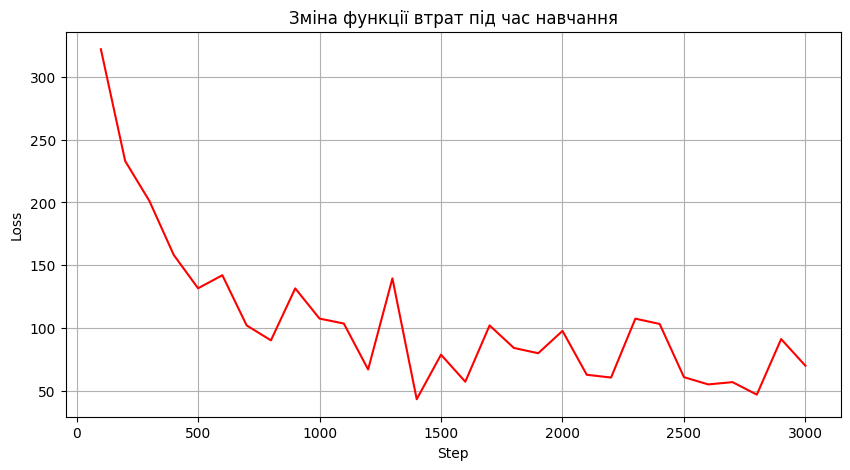

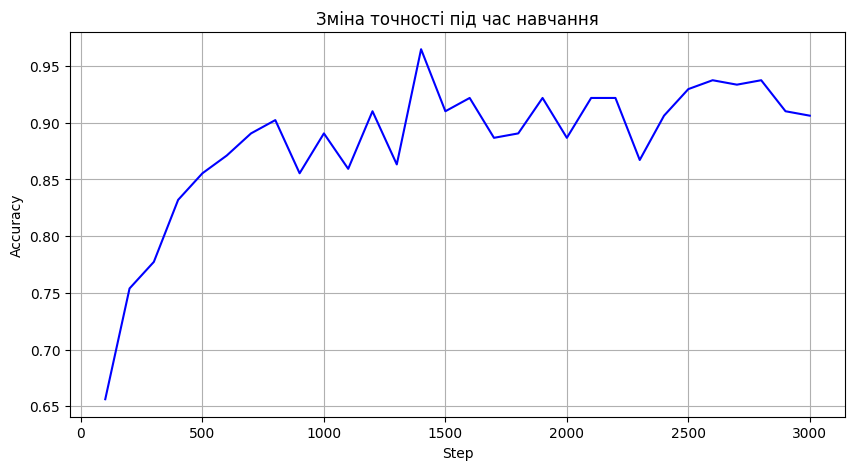

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps+1, display_step), loss_history, color='red')
plt.title("Зміна функції втрат під час навчання")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps+1, display_step), accuracy_history, color='blue')
plt.title("Зміна точності під час навчання")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [16]:
# Обчисліть точність навченої нейромережі
from sklearn.metrics import classification_report
train_acc = []
for batch_x, batch_y in train_data.take(training_steps):
    pred = neural_net(batch_x)
    acc = accuracy(pred, batch_y)
    train_acc.append(acc.numpy())
print("Train accuracy:", sum(train_acc) / len(train_acc))

# Тестування моделі на тестових даних ( метрики якості )
pred_test = neural_net(x_test)
pred_classes = tf.argmax(pred_test, axis=1).numpy()
report = classification_report(y_test, pred_classes, digits=4)
print(report)

Train accuracy: 0.92121613
              precision    recall  f1-score   support

           0     0.9503    0.9551    0.9527       980
           1     0.9771    0.9789    0.9780      1135
           2     0.8870    0.9050    0.8959      1032
           3     0.8954    0.8644    0.8796      1010
           4     0.9027    0.8971    0.8999       982
           5     0.8890    0.8711    0.8800       892
           6     0.9239    0.9384    0.9311       958
           7     0.9045    0.9212    0.9128      1028
           8     0.8563    0.8871    0.8714       974
           9     0.8877    0.8543    0.8707      1009

    accuracy                         0.9084     10000
   macro avg     0.9074    0.9073    0.9072     10000
weighted avg     0.9084    0.9084    0.9083     10000



[8157 7594 5207 4215 6580 8107 3586   94  779 8911]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[8 9 5 7 0 4 1 1 5 7]


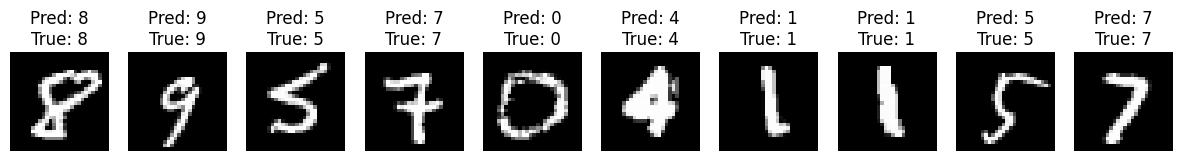

In [31]:
# Протестуйте навчену нейромережу на 10 зображеннях.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

num_random_images = 10
random_indices = np.random.choice(len(x_test), size=num_random_images, replace=False)
# print(random_indices) # [8157 7594 5207 4215 6580 8107 3586   94  779 8911]
random_images = x_test[random_indices] # беремо 10 випадкових зображень  по отриманим індексам з random_indices
print(random_images)
true_labels = y_test[random_indices] # справжні мітки які відповідають індексам конкретних випадкових зображень
print(true_labels)
# forward-pass
predictions = neural_net(random_images)
pred_classes = tf.argmax(predictions, axis=1).numpy()

# Візуалізація
plt.figure(figsize=(15, 3))
for i in range(num_random_images):
    plt.subplot(1, num_random_images, i+1)
    plt.imshow(random_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(f"Pred: {pred_classes[i]}\nTrue: {true_labels[i]}")
plt.show()



ВИСНОВОК: Нейромережа передбачила правильно 10/10 зображень. Точність для конкретної вибірки accuracy = 1.0